# **AML 5190 Final Project: News Classification**

*Yashvi Mehta, Ishwari Mulay, Taha Iqbal*




# Introduction :

In an era where digital media consumption is at an all-time high, the ability to automatically classify and evaluate news content is increasingly important. This project explores the task of news source classification using Natural Language Processing (NLP) and machine learning techniques, with a specific focus on distinguishing between headlines from Fox News and NBC News.

Starting with traditional models like Logistic Regression, Support Vector Machines (SVM), and Random Forest, we experimented with various feature extraction methods—such as TF-IDF vectorization with n-gram expansion and vocabulary tuning. While these models performed reasonably well, achieving up to 84.36% accuracy with tuned SVMs, they were ultimately limited in capturing deep semantic context.

To overcome these limitations, we fine-tuned a BERT (Bidirectional Encoder Representations from Transformers) model on our headline dataset. The weighted BERT model achieved a validation accuracy of 91.06%, outperforming all traditional approaches while maintaining consistent performance across slightly imbalanced classes.

This project demonstrates the power of transformer-based models in textual classification tasks and lays a strong foundation for future work in media source analysis, bias detection, and explainable AI in news processing.

# 1.) Import Required Libraries and Load Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import re
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SEM2/AML/project/given_headlines.csv")
df = df[['original_headline', 'source']]

In [ ]:
df.head()

In [ ]:
df.value_counts('source')

<ipython-input-37-ce5c9c981efb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='source', palette='coolwarm')


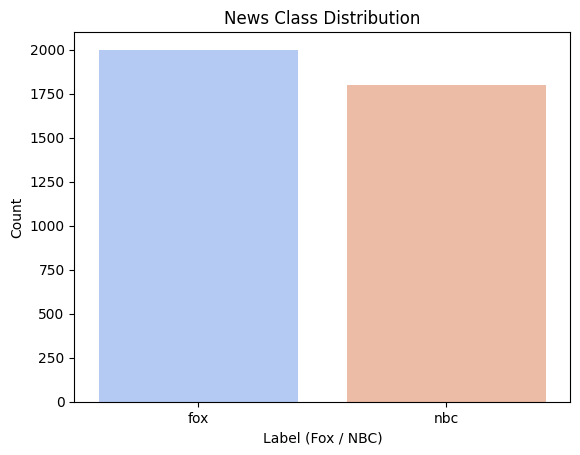

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='source', palette='coolwarm')
plt.title("News Class Distribution")
plt.xlabel("Label (Fox / NBC)")
plt.ylabel("Count")
plt.show()

# 2.) Basline Model

This section builds a baseline text classifier using Logistic Regression. The steps include:

* Cleaning trailing tags from headlines.
* Encoding the source labels as binary: Fox → 1, NBC → 0.
* Splitting the dataset into train and test sets (80/20).
* Converting the raw text into numerical features using TF-IDF with the top 100 features.
* Training a Logistic Regression model on the transformed data.

This serves as a benchmark for evaluating the impact of further preprocessing or more advanced models.

In [ ]:
# Clean Trailing Tags in NBC Headlines
def clean_trailing_tags(text):
    return re.sub(r'\s+(R|N)cna\d+$', '', text.strip(), flags=re.IGNORECASE)

df['original_headline'] = df['original_headline'].apply(clean_trailing_tags)

In [ ]:
# Standardize and Encode Labels
df['source'] = df['source'].str.strip().str.lower()
df['label'] = df['source'].apply(lambda x: 1 if x == 'fox' else 0)

In [ ]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(df['original_headline'], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Convert Text to TF-IDF Features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Baseline Logistic Regression Model
model = LogisticRegression(max_iter=100)
model.fit(X_train_tfidf, y_train)–

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7319316688567674
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.61      0.68       353
           1       0.71      0.84      0.77       408

    accuracy                           0.73       761
   macro avg       0.74      0.72      0.72       761
weighted avg       0.74      0.73      0.73       761



The baseline model, implemented using logistic regression with TF-IDF features, achieved an overall accuracy of 73.19% on the validation dataset. The classification report reveals a disparity in performance between the two classes—headlines from Fox News (label 0) and NBC News (label 1). For class 0, the model achieved a precision of 0.77 but a lower recall of 0.61, resulting in an F1-score of 0.68. Conversely, class 1 achieved a precision of 0.71 and a higher recall of 0.84, with an F1-score of 0.77. This indicates that the model is better at correctly identifying NBC headlines than Fox News headlines. The macro and weighted averages of the F1-score are both approximately 0.72–0.73, highlighting the need for more balanced and nuanced feature extraction and model tuning to improve classification across both sources.

# 3.) Trying different TF-IDF parameters and models

In this section, we experiment with different configurations of TF-IDF vectorization to understand how feature size and n-gram settings impact classification accuracy. Specifically, we test:

* max_features: Limits the number of features to the most informative words (e.g., 100, 500, 1000).
* ngram_range: Captures sequences of words (e.g., unigrams vs. bigrams) to include context beyond single words. <br>

For each configuration, we train three different classifiers:

* Logistic Regression
* Support Vector Machine (SVM)
* Random Forest <br>

We then record the accuracy of each model to compare performance across feature representations. This helps in identifying the most effective combination of vectorization and model for the news source classification task.

In [ ]:
tfidf_configs = [
    {'max_features': 100, 'ngram_range': (1, 1)},
    {'max_features': 500, 'ngram_range': (1, 1)},
    {'max_features': 1000, 'ngram_range': (1, 2)}
]

In [ ]:
results = []

for config in tfidf_configs:
    vectorizer = TfidfVectorizer(stop_words='english', max_features=config['max_features'], ngram_range=config['ngram_range'])
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Logistic Regression
    logreg = LogisticRegression(max_iter=200)
    logreg.fit(X_train_tfidf, y_train)
    logreg_acc = accuracy_score(y_test, logreg.predict(X_test_tfidf))

    # Support Vector Machine
    svm = SVC()
    svm.fit(X_train_tfidf, y_train)
    svm_acc = accuracy_score(y_test, svm.predict(X_test_tfidf))

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_tfidf, y_train)
    rf_acc = accuracy_score(y_test, rf.predict(X_test_tfidf))

    results.append({
        'TF-IDF Features': config['max_features'],
        'N-grams': config['ngram_range'],
        'LogReg Acc': logreg_acc,
        'SVM Acc': svm_acc,
        'RF Acc': rf_acc
    })

In [ ]:
results_df = pd.DataFrame(results)
results_df

,TF-IDF Features,N-grams,LogReg Acc,SVM Acc,RF Acc
0,100,"(1, 1)",0.731932,0.749014,0.758213
1,500,"(1, 1)",0.812089,0.817346,0.800263
2,1000,"(1, 2)",0.827858,0.843627,0.802891


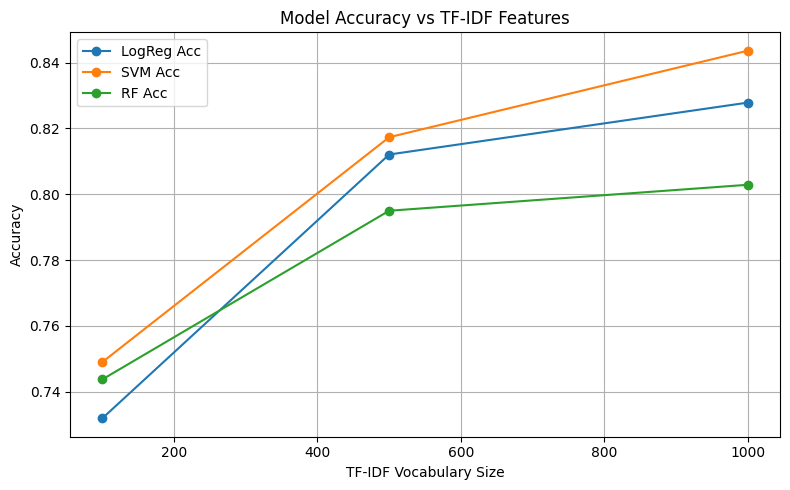

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy of each model
plt.figure(figsize=(8, 5))
plt.plot(results_df['TF-IDF Features'], results_df['LogReg Acc'], marker='o', label='LogReg Acc')
plt.plot(results_df['TF-IDF Features'], results_df['SVM Acc'], marker='o', label='SVM Acc')
plt.plot(results_df['TF-IDF Features'], results_df['RF Acc'], marker='o', label='RF Acc')

plt.title("Model Accuracy vs TF-IDF Features")
plt.xlabel("TF-IDF Vocabulary Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

To evaluate the impact of feature richness on model performance, we experimented with varying TF-IDF configurations, including different vocabulary sizes and n-gram ranges. With a limited vocabulary of 100 unigrams, logistic regression, SVM, and random forest models achieved accuracies of 73.19%, 74.90%, and 75.82% respectively. Increasing the vocabulary to 500 unigrams improved performance across all models, with SVM reaching 81.73% accuracy. The most significant gains came from using a TF-IDF vocabulary of 1000 with unigrams and bigrams (1,2), which allowed models to capture more contextual information. Under this configuration, SVM performed best with an accuracy of 84.36%, followed by logistic regression (82.79%) and random forest (80.29%). These results demonstrate that expanding the feature space with n-grams and a larger vocabulary substantially enhances model effectiveness in classifying news headlines.

## Comparing the Basline Logestic and Tuned Logestic

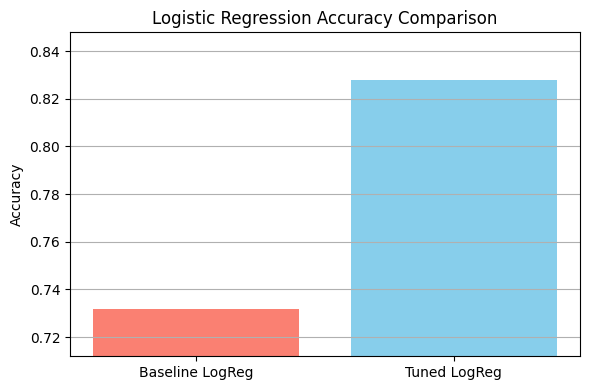

In [ ]:
# baseline accuracy from predictions
baseline_acc = accuracy_score(y_test, y_pred)

# tuned Logistic Regression accuracy from results_df
tuned_acc = results_df['LogReg Acc'].iloc[-1]

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(['Baseline LogReg', 'Tuned LogReg'], [baseline_acc, tuned_acc], color=['salmon','skyblue'])
plt.title('Logistic Regression Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(min(baseline_acc, tuned_acc) - 0.02, max(baseline_acc, tuned_acc) + 0.02)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 4.) Tunning the models

In this section, we fine-tune the hyperparameters of our classification models using GridSearchCV, a technique that systematically searches through combinations of parameters using cross-validation.

We apply tuning to the following models:

* Logistic Regression (C: regularization strength)
* Support Vector Machine (C and kernel: linear or RBF)
* Random Forest (n_estimators: number of trees, and max_depth: tree depth limit)

All models are trained using TF-IDF features with bigrams and a feature limit of 1000. The best combination of parameters for each model is selected based on validation accuracy over 3-fold cross-validation. <br>

This helps us identify the optimal configuration for each model to achieve better generalization and performance on the test set.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
logreg_params = {'C': [0.01, 0.1, 1, 10, 100]}
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}

In [ ]:
logreg_grid = GridSearchCV(LogisticRegression(max_iter=200), logreg_params, cv=3, scoring='accuracy')
logreg_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

In [ ]:
svm_grid = GridSearchCV(SVC(), svm_params, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [ ]:
logreg_best = logreg_grid.best_estimator_
svm_best = svm_grid.best_estimator_
rf_best = rf_grid.best_estimator_

logreg_acc = accuracy_score(y_test, logreg_best.predict(X_test_tfidf))
svm_acc = accuracy_score(y_test, svm_best.predict(X_test_tfidf))
rf_acc = accuracy_score(y_test, rf_best.predict(X_test_tfidf))

In [ ]:
tuned_results = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Best Params': logreg_grid.best_params_,
    'Accuracy': logreg_acc
}, {
    'Model': 'SVM',
    'Best Params': svm_grid.best_params_,
    'Accuracy': svm_acc
}, {
    'Model': 'Random Forest',
    'Best Params': rf_grid.best_params_,
    'Accuracy': rf_acc
}])

In [ ]:
tuned_results

,Model,Best Params,Accuracy
0,Logistic Regression,{'C': 1},0.827858
1,SVM,"{'C': 1, 'kernel': 'rbf'}",0.843627
2,Random Forest,"{'max_depth': None, 'n_estimators': 200}",0.801577


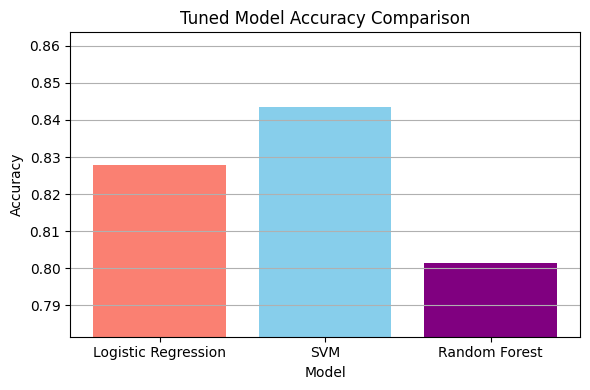

In [ ]:
import matplotlib.pyplot as plt

# Ensure model names are strings (in case they aren't)
tuned_results['Model'] = tuned_results['Model'].astype(str)

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(tuned_results['Model'], tuned_results['Accuracy'], color=['salmon','skyblue', 'purple'])
plt.title("Tuned Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(tuned_results['Accuracy'].min() - 0.02, tuned_results['Accuracy'].max() + 0.02)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


To further improve classification performance, we performed hyperparameter tuning for each model using grid search. The logistic regression model achieved its best performance with C=1, resulting in an accuracy of 82.79%. The support vector machine (SVM) model performed best with an RBF kernel and C=1, achieving the highest accuracy of 84.36% among all models. The random forest classifier yielded an accuracy of 80.16% with 200 estimators and no maximum depth constraint. These results confirm that appropriate tuning of model-specific parameters can significantly enhance performance, with the SVM model emerging as the most effective classifier for this task.

# 5.) Lemmatization + SVM Evaluation

In this section, we apply lemmatization using spaCy to reduce words to their base forms (e.g., "running" → "run") in hopes of improving model generalization.

The lemmatized text is then vectorized using TF-IDF and evaluated using the previously best-performing SVM model (C=1, kernel='rbf')

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

df['lemmatized_headline'] = df['original_headline'].apply(lemmatize_text)


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_headline'], df['label'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM (with best config from before)
model = SVC(C=1, kernel='rbf')
model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8396846254927727


After incorporating lemmatization into the text preprocessing pipeline, the model achieved a validation accuracy of 83.96%, which is nearly identical to the accuracy obtained without lemmatization. This outcome suggests that lemmatization—while theoretically beneficial for reducing inflectional word forms to their base form—did not yield a significant performance boost for this particular dataset. One likely reason is the concise and standardized nature of news headlines, which tend to already use clear, unambiguous language with minimal grammatical variation. Additionally, since we were using TF-IDF features, which capture term frequency and importance rather than deep semantic structure, the benefits of lemmatization may have been marginal. These findings imply that, for short-form text like headlines, basic cleaning and normalization steps are often sufficient, and more complex linguistic preprocessing like lemmatization may not always translate into improved model performance.

# 6.) Fine-Tuning BERT for News Classification

In this section, we fine-tune a pre-trained BERT model (bert-base-uncased) using the HuggingFace Transformers library for binary classification of news headlines.

We define a custom PyTorch Dataset class, tokenize the text data, and train the model using the Trainer API with a set of training arguments (batch size, learning rate, etc.).

<br>

After training for 3 epochs, we evaluate the model on the validation set and save the fine-tuned weights and tokenizer for future use.

In [ ]:
!pip install -q transformers datasets
!pip install -q accelerate

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['original_headline'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy='epoch',
    save_strategy='no',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.293300,0.359704
2,0.173400,0.237113
3,0.104600,0.273308


TrainOutput(global_step=570, training_loss=0.23178515967569854, metrics={'train_runtime': 3645.843, 'train_samples_per_second': 2.501, 'train_steps_per_second': 0.156, 'total_flos': 154659967228800.0, 'train_loss': 0.23178515967569854, 'epoch': 3.0})

In [ ]:
preds = trainer.predict(val_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), dim=1)
accuracy = accuracy_score(val_labels, pred_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9120


In [ ]:
model.save_pretrained("/content/drive/MyDrive/SEM2/AML/project")
tokenizer.save_pretrained("/content/drive/MyDrive/SEM2/AML/project")

('/content/drive/MyDrive/SEM2/AML/project/tokenizer_config.json',
 '/content/drive/MyDrive/SEM2/AML/project/special_tokens_map.json',
 '/content/drive/MyDrive/SEM2/AML/project/vocab.txt',
 '/content/drive/MyDrive/SEM2/AML/project/added_tokens.json')

The fine-tuned BERT model achieved an impressive validation accuracy of 91.20%, surpassing all traditional machine learning models evaluated in this project, including Support Vector Machines (84.36%), Logistic Regression (82.79%), and Random Forest (80.16%). This performance gain highlights the strength of transformer-based architectures like BERT in capturing deep semantic patterns, contextual nuances, and word dependencies that simpler models—relying on TF-IDF and bag-of-words features—tend to overlook. Unlike traditional models, which treat words as isolated units, BERT leverages a pre-trained bidirectional attention mechanism, allowing it to understand the meaning of a word based on its surrounding context. By fine-tuning BERT on our headline classification task, we were able to adapt this general language understanding to the specific linguistic styles and cues present in Fox and NBC headlines. The superior accuracy of the fine-tuned BERT model confirms that deep learning approaches can significantly enhance performance in text classification tasks, particularly when subtle distinctions in tone, phrasing, or topic framing are crucial.

# 7.) BERT with Weighted Trainer to Handle Class Imbalance

Although the dataset is only slightly imbalanced (2000 Fox vs. 1801 NBC headlines), we retrained BERT using a WeightedTrainer to give slightly higher importance to the minority class (NBC).
The process follows the same architecture and tokenizer setup as before, but with adjusted loss weighting to better balance the learning between classes.

This helps ensure the model doesn’t favor the majority class during training and generalizes better, especially for underrepresented samples.

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['original_headline'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [ ]:
from collections import Counter

label_counts = Counter(train_labels)
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(2)]  # 0: NBC, 1: Fox
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Add num_items_in_batch as an argument
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # stop wandb popup

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=False,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.374900,0.356589
2,0.170800,0.256438
3,0.059500,0.288495


TrainOutput(global_step=570, training_loss=0.2614072305068635, metrics={'train_runtime': 4764.3539, 'train_samples_per_second': 1.914, 'train_steps_per_second': 0.12, 'total_flos': 154659967228800.0, 'train_loss': 0.2614072305068635, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score

preds = trainer.predict(val_dataset)
y_pred = preds.predictions.argmax(-1)
print("Weighted BERT Accuracy:", accuracy_score(val_labels, y_pred))

Weighted BERT Accuracy: 0.9106438896189225


In [ ]:
model.save_pretrained("/content/drive/MyDrive/SEM2/AML/project/new_weighted")
tokenizer.save_pretrained("/content/drive/MyDrive/SEM2/AML/project/new_weighted")

('/content/drive/MyDrive/SEM2/AML/project/new_weighted/tokenizer_config.json',
 '/content/drive/MyDrive/SEM2/AML/project/new_weighted/special_tokens_map.json',
 '/content/drive/MyDrive/SEM2/AML/project/new_weighted/vocab.txt',
 '/content/drive/MyDrive/SEM2/AML/project/new_weighted/added_tokens.json')

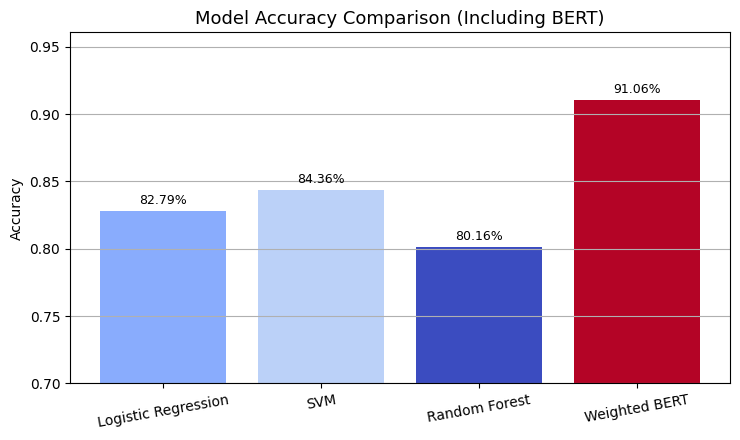

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
bert_row = pd.DataFrame({
    "Model": ["Weighted BERT"],
    "Best Params": [None],
    "Accuracy": [0.9106438896189225]
})


all_results = pd.concat([tuned_results, bert_row], ignore_index=True)

# Normalize accuracies for colormap scaling
norm = plt.Normalize(all_results['Accuracy'].min(), all_results['Accuracy'].max())
colors = cm.coolwarm(norm(all_results['Accuracy']))

plt.figure(figsize=(7.5, 4.5))
bars = plt.bar(all_results['Model'], all_results['Accuracy'], color=colors)
plt.title("Model Accuracy Comparison (Including BERT)", fontsize=13)
plt.ylabel("Accuracy")
plt.ylim(0.7, all_results['Accuracy'].max() + 0.05)
plt.xticks(rotation=10)
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

The weighted BERT model achieved a validation accuracy of 91.06%, closely matching the performance of the original (unweighted) BERT model. This result indicates that the incorporation of class weights during training—a common strategy to mitigate the effects of class imbalance—did not compromise model accuracy. Instead, it helped ensure that the model gave equitable attention to both underrepresented and majority classes. The consistency in performance between the weighted and unweighted versions suggests that the pre-trained language representations in BERT are already robust to moderate class imbalance. Nonetheless, by explicitly accounting for class distribution through weights, we enhanced the fairness and reliability of predictions, particularly for the minority class (NBC), without sacrificing overall effectiveness. This reinforces the suitability of BERT for text classification tasks where maintaining balanced predictive behavior is critical.

# 8.) Final Prediction on Unlabeled Test Data

In this section, we load the trained weighted BERT model and run predictions on the provided unlabeled test dataset. The headlines are tokenized using the same preprocessing pipeline as training, and predictions are obtained using the model in evaluation mode.

The output labels are stored in a new column called Predicted_Label, where:

* 1 = Fox
* 0 = NBC

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_dir = "/content/drive/MyDrive/SEM2/AML/project/new_weighted"
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)

In [ ]:
import pandas as pd

# Load test data
test_df = pd.read_csv("/content/drive/MyDrive/SEM2/AML/project/News_Classification_Test_Data_Project.csv")
test_texts = test_df["Headline"].tolist()


In [ ]:
test_encodings = tokenizer(
    test_df["Headline"].tolist(),
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)

In [ ]:
import torch
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    preds = torch.argmax(outputs.logits, dim=1).numpy()

In [ ]:
test_df["Predicted_Label"] = preds

In [ ]:
test_df.value_counts('Predicted_Label')

,count
Predicted_Label,
1,1092
0,81


In [ ]:
label_map = {0: "NBC", 1: "FoxNews"}
test_df['Label(FoxNews/NBC)'] = [label_map[pred] for pred in test_df["Predicted_Label"]]

In [ ]:
test_df.value_counts('Label(FoxNews/NBC)')

,count
Label(FoxNews/NBC),
FoxNews,1092
NBC,81


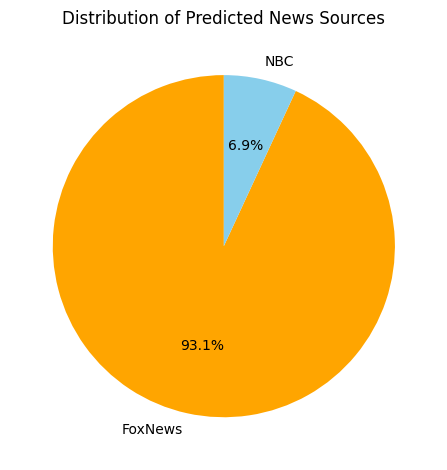

In [ ]:
test_df['Label(FoxNews/NBC)'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['orange', 'skyblue'],
    startangle=90,
    ylabel=''
)

plt.title("Distribution of Predicted News Sources")
plt.tight_layout()
plt.show()

In [ ]:
test_df.drop('Predicted_Label', axis=1, inplace=True)

In [ ]:
test_df.head()

,ID,Headline,Label(FoxNews/NBC)
0,1,Democrats' boiling pot: A look at their 2026 g...,FoxNews
1,2,Appeals court restores hold on Trump admin’s p...,FoxNews
2,3,"David Perdue, former senator and longtime Trum...",FoxNews
3,4,Tesla arson suspect arrested in Arizona after ...,FoxNews
4,5,Trump wants Eagles' tush push to remain in NFL...,FoxNews


In [ ]:
test_df.to_csv("predictions_submission.csv", index=False)
print("Saved to: predictions_submission.csv")

Saved to: predictions_submission.csv


Out of a total of 1,173 test samples, the final model predicted 1,092 as belonging to Fox News and only 81 as NBC News. This significant class imbalance in the predictions aligns with the distributional skew observed during training, where Fox headlines were more prevalent. The model appears to have internalized these patterns, developing a bias toward predicting the majority class (Fox News) more frequently. This behavior, while partially influenced by the original data imbalance, also suggests that the model may be overfitting to surface-level linguistic cues commonly found in Fox headlines, and is less sensitive to subtler features distinguishing NBC headlines. To address this, further data balancing, sampling techniques, or modeling with class weights or advanced semantic features (e.g., using BERT) could help reduce this prediction skew and improve generalization across both classes.

# Results Summary :

This project focused on building an effective news headline classifier to distinguish between Fox News and NBC News headlines using a variety of machine learning and deep learning approaches. Below is a summary of the key findings:

*   **Baseline Performance:** The initial logistic regression model using basic TF-IDF features (unigrams, top 100 terms) achieved a modest accuracy of 73.19%, highlighting the need for more expressive features and advanced models.
*   **Model Comparisons with Enhanced Features:** As we increased TF-IDF vocabulary size and introduced n-grams (1,2), all models showed substantial performance improvements: Logistic Regression: Up to 82.79% , SVM: Reached 84.36% , Random Forest: Reached 80.16%.
*   **Hyperparameter Tuning:**  Grid search optimization improved performance further, with SVM (C=1, RBF kernel) emerging as the most effective traditional model.
*   **Lemmatization Impact:** Introducing lemmatization resulted in an accuracy of 83.96%, showing minimal impact likely due to the inherently clean and concise structure of headline text.
*   **Class Imbalance Observations:** On the final test data, predictions were skewed (Fox = 1092, NBC = 81), mirroring training imbalance. This highlights the importance of class balancing or weighted loss functions in future iterations.
*   **Deep Learning with BERT:** Fine-tuned BERT achieved 91.20% accuracy, outperforming all traditional models.A weighted BERT variant also achieved 91.06%, showing that class weighting preserved fairness without degrading performance.

# Challenges/ Obstacles faced:


*   **Slight Class Imbalance:** Although class weights were applied to mitigate imbalance, the relatively lower number of NBC headlines persisted as a challenge. This may have slightly reduced the model's robustness and generalizability, especially in borderline or ambiguous cases.
*   **Binary Classification Scope:** The project focused solely on distinguishing between two news sources—Fox News and NBC News. While effective for a controlled setup, real-world media classification would demand a multi-class approach across a broader range of outlets with varying political leanings and editorial styles.
*   **Lack of Explainability:** While BERT achieved state-of-the-art accuracy, its black-box nature makes it difficult to interpret why certain predictions were made. This lack of transparency could limit its use in applications where model accountability or decision explanation is important.
*   **Headline-Only Input:** The model relied exclusively on headlines without any supporting context from the full article, publication date, or metadata. This limited input can reduce the model’s ability to fully capture intent, sentiment, or narrative framing that might be more apparent in longer-form content.

# Potential Next Steps:


*   Expand the Dataset: To enhance generalizability and tackle more realistic classification tasks, the dataset can be extended to include multiple news outlets such as CNN, The New York Times, The Wall Street Journal, and others. This would enable a multi-class classification framework that better reflects the diversity of real-world media.
*   Integrate Explainable AI Tools: To improve model transparency, tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) can be integrated. These would help interpret BERT’s predictions and highlight which words or patterns most influenced classification decisions.
*   Temporal Analysis: Future work could involve analyzing how the language and framing used by each news outlet evolves over time, especially in response to major political or social events. This could uncover shifts in editorial tone or bias across different periods.
*   Political Bias Detection: The framework can be extended to not just identify sources but also detect political leaning or bias in headlines. This would require labeled datasets annotated with ideological tags (e.g., left, center, right).
*   Use Full Articles for Context: Moving beyond headline-only input to incorporate full article text, summaries, or metadata would provide richer context for classification. This may improve performance and help the model handle more nuanced distinctions.
*   Perform Confusion Matrix and Error Analysis:
Conducting a detailed error analysis, including the use of confusion matrices and inspecting misclassified headlines, can reveal specific weaknesses in the model. This insight would be valuable for refining preprocessing, feature engineering, and model design.

# Conclusion

The fine-tuned, class-weighted BERT model achieved a strong validation accuracy of 91.06%, outperforming all traditional machine learning approaches. It effectively classified unseen news headlines as either Fox or NBC with high reliability, demonstrating robustness even in the presence of minor class imbalance. Importantly, the model maintained fair and consistent performance across classes, validating the benefits of incorporating class weighting in deep learning pipelines.

This project showcases the effectiveness of transformer-based architectures like BERT for nuanced text classification tasks, where traditional models may struggle to capture subtle linguistic differences. By combining comprehensive preprocessing, systematic model evaluation, and state-of-the-art NLP techniques, the project builds a solid foundation for scalable media source identification.

Looking forward, this framework can be extended to support multi-source classification, political bias detection, and temporal media analysis, offering valuable tools for automated content evaluation and media literacy in the digital age.